In [33]:
%pip install xarray-regrid netcdf4 matplotlib zarr gcsfs


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
from dask import distributed

c = distributed.Client()

/Users/clairedonnelly/AI4S2S/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60615 instead
  warnings.warn(


In [35]:
import xarray as xr
import xarray_regrid

In [36]:
ds_vars = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options={"token": "anon"},
)

ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks={"time": 1, "latitude": -1, "longitude": -1},
    storage_options={"token": "anon"},
    drop_variables=[v for v in ds_vars.data_vars if v != "sea_surface_temperature"],
)

ar_full_37_1h = ds.sel(
    time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"])
)
ar_full_37_1h

<xarray.Dataset> Size: 3TB
Dimensions:                  (latitude: 721, level: 37, longitude: 1440,
                              time: 741456)
Coordinates:
  * latitude                 (latitude) float32 3kB 90.0 89.75 ... -89.75 -90.0
  * level                    (level) int64 296B 1 2 3 5 7 ... 925 950 975 1000
  * longitude                (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                     (time) datetime64[ns] 6MB 1940-01-01 ... 2024-07...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 3TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [37]:
ds_reduced = ar_full_37_1h.sel(
    latitude=slice(70, -70, 4), longitude=slice(150, 240, 4), time=slice("1960", "2020")
).isel(time=slice(None, None, 36))
ds_reduced = ds_reduced.chunk({"time": 30, "latitude": -1, "longitude": -1})


In [38]:
ds_grid = xarray_regrid.Grid(
    north=70,
    south=-70,
    east=240,
    west=150,
    resolution_lat=5,
    resolution_lon=5
).create_regridding_dataset()

In [39]:
sst_regrid = ds_reduced["sea_surface_temperature"].sortby(["latitude", "longitude"]).regrid.stat(ds_grid, method="mean")

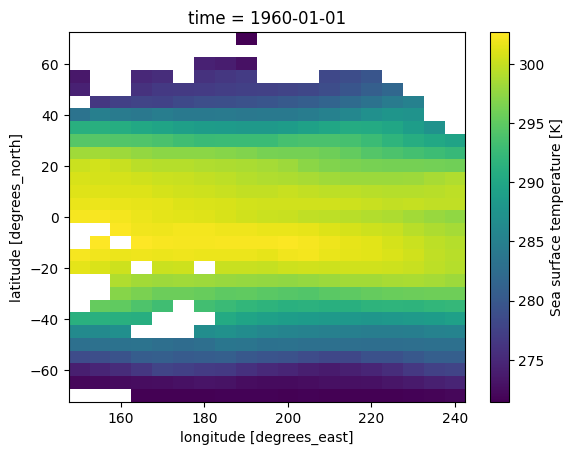

In [40]:
sst_regrid.isel(time=0).plot()

In [41]:
sst_regrid.load()

<xarray.DataArray 'sea_surface_temperature' (time: 14854, latitude: 29,
                                             longitude: 19)> Size: 33MB
array([[[      nan,       nan,       nan, ..., 271.6233 , 271.74448,
         271.95648],
        [271.9862 , 272.10074, 272.34775, ..., 273.65158, 274.17517,
         274.5737 ],
        [274.1253 , 274.7368 , 275.31702, ..., 276.52823, 277.54727,
         277.80408],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 271.63492, 271.76508,
         271.9971 ],
        [272.02054, 272.13953, 272.38553, ..., 273.69604, 274.221  ,
         274.60178],
        [274.18945, 274.7888 , 275.3627 , ..., 276.58533, 277.62317,
         277.87842],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 271.50873, 271.46014,
         271.46024],
        [272.44394, 272.43512, 272.37698, ..., 272.51797, 272.69067,
         273.02448],
        [273.58987, 274.3841 , 274.91327, ..., 275.4167 , 275.92075,
         275.89716],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 119kB 1960-01-01 ... 2020-12-30T12:00:00
  * longitude  (longitude) int64 152B 150 155 160 165 170 ... 225 230 235 240
  * latitude   (latitude) int64 232B -70 -65 -60 -55 -50 -45 ... 50 55 60 65 70
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K